## Geodesic Solver for Equatorial Lightlike Trajectories
The problem is for massless particles, and only along the equator. This removes the $\theta$ variable and its derivatives from consideration, setting $\theta = \frac{\pi}{2}$ where the variable would otherwise show up.

Since the first order equations were a pain to use for finding trajectories numerically, I have moved on to solving the geodesic equation.

Strategy: use sympy as a replacement for mathematica to find christoffel symbols, then numerically solve the geodesic equation (which is second order).
I begin by setting up appropriate symbolic variables for deriving the appropriate christoffel symbols.

In [90]:
from sympy import Symbol,diff, symbols, Matrix, simplify
import sympy.diffgeom as dg
from sympy.diffgeom import Manifold, Patch, TensorProduct
import numpy as np

m=Manifold('M',3)
p=Patch('P',m)



t,phi,r = symbols('t phi r')
tp,phip,rp = symbols(("\dot{t}", "\dot{\phi}","\dot{r}" ))
tpp,phipp,rpp =symbols("t'' phi'' r''")

coords=[t,phi,r]
coordsp=[tp,phip,rp]
coordspp=[tpp,phipp,rpp]

BL=dg.CoordSystem('Boyer-Lindquist',p,[t,phi,r])



s=Symbol('s')
a=Symbol('a')



Next, I define the commonly-used shorthand function $\Delta (r)$ for expressing the Kerr metric in Boyer-Lindquist Coordinates.

In [91]:
def Delta(r):
    delta=r**2 + a**2-r*s
    return delta

I now symbolically define the Kerr metric via tensor products of one-forms and their appropriate coefficients.

In [92]:
tt=-(1-s/r)
tphi=-a*s/r
phiphi=r**2+a**2+a**2*s/r
rr=r**2/Delta(r)

metric_components = Matrix([[tt,tphi,0],[tphi,phiphi,0],[0,0,rr]])
(dt,dphi,dr)=BL.base_oneforms()

metric = tt*TensorProduct(dt,dt) +tphi*TensorProduct(dt,dphi)+ tphi*TensorProduct(dphi,dt)+phiphi*TensorProduct(dphi,dphi)+rr*TensorProduct(dr,dr)


print(metric_components)

print(dg.twoform_to_matrix(metric))
metric

Matrix([[-1 + s/r, -a*s/r, 0], [-a*s/r, a**2 + a**2*s/r + r**2, 0], [0, 0, r**2/(a**2 + r**2 - r*s)]])
Matrix([[-1 + s/r, -a*s/r, 0], [-a*s/r, a**2 + a**2*s/r + r**2, 0], [0, 0, r**2/(a**2 + r**2 - r*s)]])


-a*s*TensorProduct(dt, dphi)/r - a*s*TensorProduct(dphi, dt)/r + r**2*TensorProduct(dr, dr)/(a**2 + r**2 - r*s) + (-1 + s/r)*TensorProduct(dt, dt) + (a**2 + a**2*s/r + r**2)*TensorProduct(dphi, dphi)

That's encouraging.
I tried using the sympy package to generate christoffel symbols directly, but this did not work. It simply returned zero for all symbols.
Instead, I implement the formula for christoffel symbols using derivatives of the metric and contraction with the inverse metric.

In [93]:
christoff_doesnt_work=dg.metric_to_Christoffel_2nd(metric)
christoff_doesnt_work
#this shit do not be working
#seems to be fundamentally broken, so I'll do it myself

[[[0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0]]]

In [94]:
from sympy.tensor.array import MutableDenseNDimArray
def christoffel_single(metric_matrix,coords,index1,index2,index3):
    dim=len(coords)
    partialsum=0
    for beta in range(dim):
        partialsum += 1/2*metric_matrix.inv()[index1,beta]*(diff(metric_matrix[beta,index2],coords[index3])+diff(metric_matrix[beta,index3],coords[index2])-diff(metric_matrix[index2,index3],coords[beta]))
    christf_single=partialsum
    return christf_single

def christoffel_symbols(metric,coords):
    dim=len(coords)
    christoffel_total=MutableDenseNDimArray.zeros(dim,dim,dim)
    
    for i in range(dim):
        for j in range(dim):
            for k in range(dim):
                christoffel_total[i,j,k]=christoffel_single(metric,coords,i,j,k)
    return christoffel_total

I split it into a function that finds individual symbols, and one that packages it all together into one object with the three indices you'd expect.
Calling it from within a simplify call yields a correct set of symbols for the Kerr metric - I checked this against "Catalogue of Spacetimes" by Mueller and Grave (cited formally elsewhere)

In [95]:
christoff_pretty=simplify(christoffel_symbols(metric_components,coords))
christoff_pretty

[[[0, 0, 0.5*s*(a**2 + r**2)/(r**2*(a**2 + r**2 - r*s))], [0, 0, -0.5*a*s*(a**2 + 3*r**2)/(r**2*(a**2 + r**2 - r*s))], [0.5*s*(a**2 + r**2)/(r**2*(a**2 + r**2 - r*s)), -0.5*a*s*(a**2 + 3*r**2)/(r**2*(a**2 + r**2 - r*s)), 0]], [[0, 0, 0.5*a*s/(r**2*(a**2 + r**2 - r*s))], [0, 0, 1.0*(-0.5*a**2*s + 1.0*r**3 - 1.0*r**2*s)/(r**2*(a**2 + r**2 - r*s))], [0.5*a*s/(r**2*(a**2 + r**2 - r*s)), 1.0*(-0.5*a**2*s + 1.0*r**3 - 1.0*r**2*s)/(r**2*(a**2 + r**2 - r*s)), 0]], [[0.5*s*(a**2 + r**2 - r*s)/r**4, 0.5*a*s*(-a**2 - r**2 + r*s)/r**4, 0], [0.5*a*s*(-a**2 - r**2 + r*s)/r**4, 0.5*(a**2*s - 2*r**3)*(a**2 + r**2 - r*s)/r**4, 0], [0, 0, 1.0*(1.0*a**2 - 0.5*r*s)/(r*(a**2 + r**2 - r*s))]]]

I then used the geodesic equation to write the second derivative of each coordinate as an expression involving derivatives of coordinates and the christoffel symbols.

We start with $\ddot{t}$:

In [96]:
def geod_second_deriv(coordinate,coords,coord_derivs,christoffel_symbols_all):
    dim=len(coords)
    coordIndex=coords.index(coordinate)
    
    expression=0
    for i in range(dim):
        for j in range(dim):
            expression+=-christoffel_symbols_all[coordIndex,i,j]*coord_derivs[i]*coord_derivs[j]
    return expression

z=Symbol('z')


t_second_der=simplify(geod_second_deriv(t,coords,coordsp,christoff_pretty))
simplify(t_second_der)

1.0*\dot{r}*s*(\dot{\phi}*a*(a**2 + 3*r**2) - \dot{t}*(a**2 + r**2))/(r**2*(a**2 + r**2 - r*s))

Now $\ddot{\phi}$:

In [97]:
phi_second_der=simplify(geod_second_deriv(phi,coords,coordsp,christoff_pretty))
phi_second_der


\dot{r}*(2.0*\dot{\phi}*(0.5*a**2*s - 1.0*r**3 + 1.0*r**2*s) - 1.0*\dot{t}*a*s)/(r**2*(a**2 + r**2 - r*s))

And $\ddot{r}$:

In [98]:
r_second_der=simplify(geod_second_deriv(r,coords,coordsp,christoff_pretty))
r_second_der

(\dot{r}**2*r**3*(-1.0*a**2 + 0.5*r*s) + (a**2 + r**2 - r*s)**2*(-0.5*\dot{\phi}**2*(a**2*s - 2*r**3) + 1.0*\dot{\phi}*\dot{t}*a*s - 0.5*\dot{t}**2*s))/(r**4*(a**2 + r**2 - r*s))

Now I turn these symbolic expressions into lambda functions which I can then actually call with arguments. 
I call the $\ddot{t}$ one and verify it looks as it should when supplied with symbolic arguments.

In [99]:
from sympy.utilities.lambdify import lambdify

variablestuple=(t,phi,r,tp,phip,rp,a,s)
tpp_num=lambdify(variablestuple,t_second_der)
phipp_num=lambdify(variablestuple,phi_second_der)
rpp_num=lambdify(variablestuple,r_second_der)

tpp_num(t,phi,r,tp,phip,rp,a,s)

1.0*\dot{r}*s*(\dot{\phi}*a*(a**2 + 3*r**2) - \dot{t}*(a**2 + r**2))/(r**2*(a**2 + r**2 - r*s))

Now things get a little messier. I redefine my a and s variables numerically, overwriting their attachment to symbols. 

In short, I define control variables for the black hole params: M, and a.
I do the same for initial conditions on my light ray. 
There are still some lowercase $m$ variables left in (set to zero) so that adapting to massive particles won't be quite as much of a wild goose chase if I ever do it.

The $\dot{t}$ Initial condition needs to be derived from the other first derivative initial conditions.
I use a formula I derived by hand by solving hte quadratic equation, but I include a backstop numerical solver for the case when my analytical solution divides by zero.


In [100]:
import math
from scipy.optimize import fsolve
import numpy as np



#black hole params
a=0.9 #BH spin param
M=1 #BH mass param
s=2*M #BH schwartzchild radius
#horizon radii
r_h=(s+np.sqrt(s**2-4*a**2))/2
r_hi=(s-np.sqrt(s**2-4*a**2))/2

#photon orbit
r_prograde_photon_orbit=s*(1+np.cos(2/3*np.arccos(-np.abs(a)/M)))
r_cutoff=1.01*r_h#(r_h+r_prograde_photon_orbit)/2


#ergoregion (valid only in equatorial plane)
r_e=2*M
r_ei=0
#test particle
m=0.00 #particle mass
r_0=r_e*1.01 #initial radial pos
rp_0=0 #initial radial momentum

phi_0=0 #initial angular pos
phip_0=-0.00020395#initial angular (pseudo?)momentum

t_0=0


#solve for the 
init_cond_equation=lambda tdot : m**2 -(1-s/r_0)*tdot**2 - 2*a*s*phip_0*tdot/r_0+(r_0**2+a**2+a**2*s/r_0)*phip_0**2+rp_0**2*r_0**2/(Delta(r_0))
try:
    tp_0_guess=(-a*s*phip_0/r_0+math.sqrt(a*a*s*phip_0*phip_0/r_0 + (1-s/r_0)*(m**2 + (r_0**2+a**2)*phip_0**2 + (r_0*rp_0)**2/Delta(r_0))))/(1-s/r_0)
    #this guess is the analytic solution assuming r is not equal to s and that initial conditions exist
except ZeroDivisionError:
    tp_0_guess =0.05

tp_0_guess,infodict,boolsuccess,message=fsolve(init_cond_equation,tp_0_guess,full_output=True)
if boolsuccess:
    tp_0=tp_0_guess[-1]
else:
    raise Exception("Invalid initial conditions, no value for t prime could be found")
if tp_0 <=0:
    raise Exception("Invalid initial conditions, no positive value for t prime could be found")



In [101]:
init_cond_equation(tp_0)
tp_0

0.037351261543922494

Maybe a numerical initial condition solver is a bit gross? Still, this is probably good enough. It tries using the analytical solution, which should only break if the initial radius is within the ergosphere, or if another divide by zero is encountered (which should not happen for nonzero starting radius). If the divide by zero is encountered, rather than re-derive the formula for an additional case, it will solve the equation numerically for an appropriate $\dot{t}$. It also should probably now refuse to run when it can't find a positive $\dot{t}$

If the simulation gets too choppy, decrease the starting derivatives. For example, divide all of them by ten and it will decrease the step size. Since this is a light ray, the ratio between radial and angular momentum is the physical parameter, while the scale factor determines the step size in coordinate time implicitly via $p_{\mu}p^{\mu}=-m^2$. (m=0 for light) The magnitude of the $\dot{r}, \dot{\phi}$ determines the step size with respect to lambda, the affine parameter. Smaller is more accurate.

Next, I write a function for the equation of motion: It takes in a current state of the variables $t, \phi, r, \dot{t}, \dot{\phi}, \dot{r}$ and their first derivatives with respect to the affine parameter $\lambda$, and then computes the next highest derivatives for each one so I can numerically integrate them.

Then, I create a scipy Runge-Kutta ODE solver object which I can use to solve the problem step by step.

In [102]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

def EOM(t,y):
    t=y[0]
    phi=y[1]
    r=y[2]
    dt=y[3]
    dphi=y[4]
    dr=y[5]
    
    
    dtprime=tpp_num(t,phi,r,dt,dphi,dr,a,s)
    dphiprime=phipp_num(t,phi,r,dt,dphi,dr,a,s)
    drprime=rpp_num(t,phi,r,dt,dphi,dr,a,s)

    dxmu=np.array([dt,dphi,dr,dtprime,dphiprime,drprime])
    return dxmu

lambda0=0

lambda_max=100000

y0=np.array([0,0,r_0,tp_0,phip_0,rp_0])

RK=scipy.integrate.RK45(EOM,lambda0,y0,lambda_max,max_step=0.01)

This block computes and saves each step, stopping when the light ray gets close to the event horizon or when it gets flung out to 20x its starting radius.
The cutoff is so ridiculously small and nonfunctional because a more reasonable value caused simulations for prograde photon orbits to immediately halt.

In [103]:
step_max=100000
xmu=np.zeros((step_max,6))
xmu[0,:]=y0

reachedstep=0
for lambstep in range(1,step_max):
    try:
        RK.step()   
        xmu[lambstep,:]=RK.y
        reachedstep=lambstep
    except RuntimeError:
        break
    finally:
        if(xmu[lambstep,2] <r_cutoff):
            #cutoff is so ridiculously small and therefore essentially nonfunctional because a higher more reasonable cutoff prevented the simulation of the prograde photon orbit
            break
        if(xmu[lambstep,2] > 20*r_0):
            break
        
x_trunc=xmu[0:reachedstep,:] #x without the trailing zero rows

Next, I make a few plots of the light ray's trajectory.

Text(0.5, 1.0, 'Log of Radius')

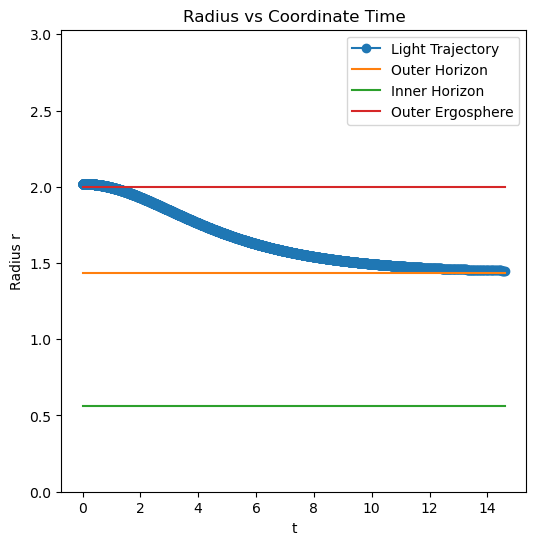

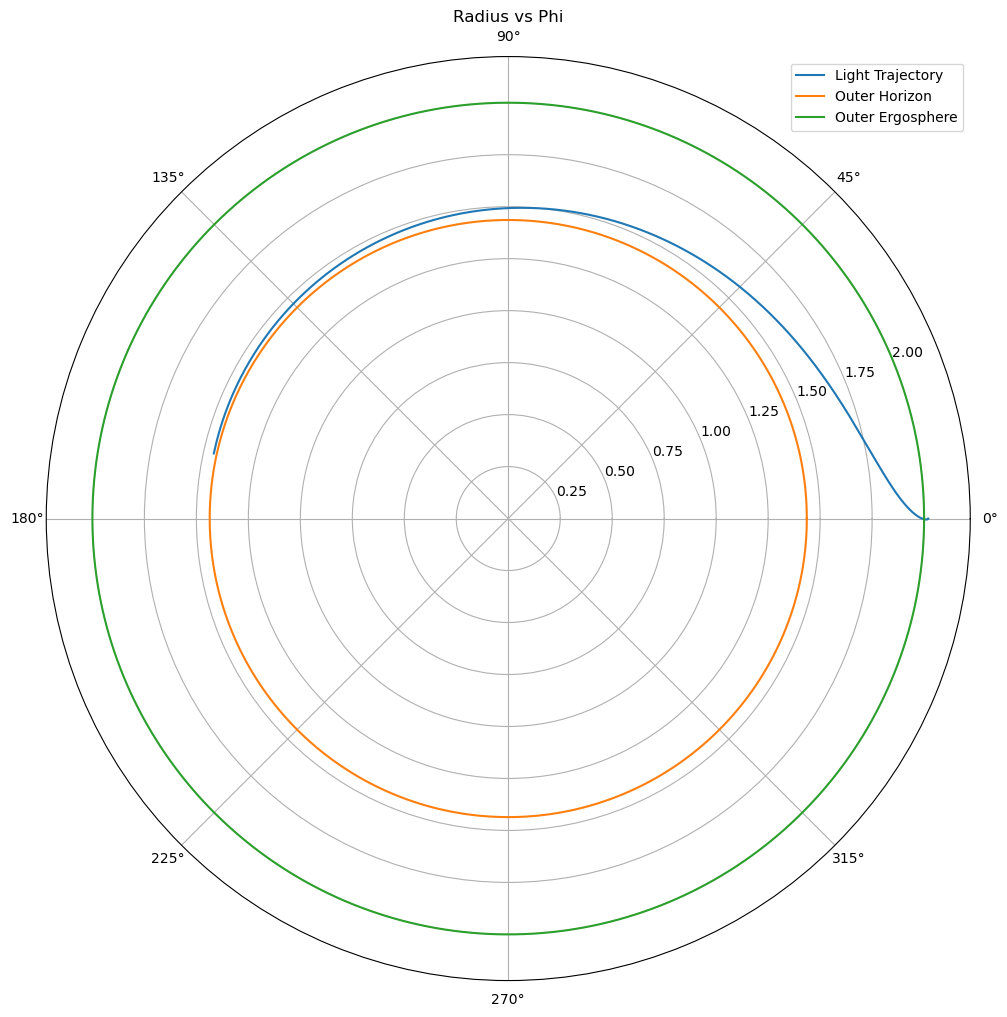

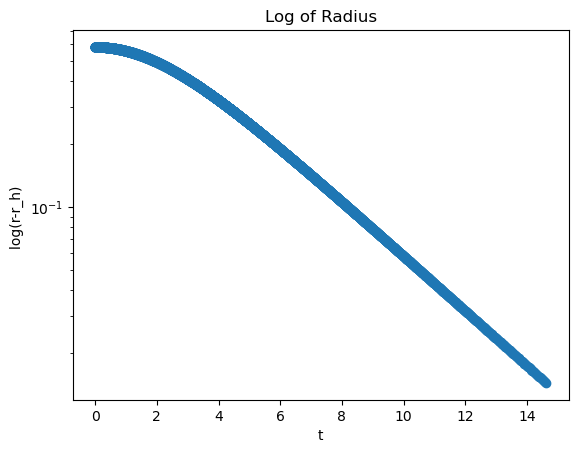

In [104]:
tmin=np.min(x_trunc[:,0])
tmax=np.max(x_trunc[:,0])
plt.figure(figsize=(6,6))
plt.plot(x_trunc[:,0],x_trunc[:,2],'-o',label='Light Trajectory')
plt.plot([tmin, tmax],[r_h,r_h],label="Outer Horizon")
plt.plot([tmin, tmax],[r_hi,r_hi],label="Inner Horizon")
plt.plot([tmin, tmax],[r_e,r_e],label="Outer Ergosphere")
plt.xlabel("t")
plt.ylabel("Radius r")
plt.title("Radius vs Coordinate Time")
plt.ylim([0,r_0*1.5])
plt.legend()
#polar plot
fig2, ax2 = plt.subplots(figsize=(12,12),subplot_kw={'projection':'polar'})

#setup horizon plotting
numpts=300
th_hor=np.linspace(0,2*np.pi,num=numpts)
ones_arr=np.ones((numpts))
rh_arr=ones_arr*r_h
rhi_arr=ones_arr*r_hi
re_arr=ones_arr*r_e
#plot trajectory
ax2.plot(x_trunc[:,1],x_trunc[:,2],label='Light Trajectory')
#plot horizon
ax2.plot(th_hor,rh_arr,label='Outer Horizon')
ax2.plot(th_hor,re_arr,label='Outer Ergosphere')
#ax2.plot(th_hor,rhi_arr)
plt.title("Radius vs Phi")
plt.ylim([0,r_0*1.1])
plt.legend()


plt.figure()
plt.semilogy(x_trunc[:,0],x_trunc[:,2]-r_h,'-o')
plt.xlabel("t")
plt.ylabel("log(r-r_h) ")
plt.title("Log of Radius")

So with initial conditions of light propagating against the rotation direction right outside of the ergosphere, it immediately falls in and is carried with that rotation. The ergosphere is where even light must follow the rotation.

Now, I wanted to make this a bit easier to work with and generate plots for, so cut up and reassembled previous sections fo the code into more easily callable functions to solve for trajectories given initial conditions.

There's functions for completing initial conditions by solving for $\dot{t}$, functions for finding the trajectory given the initial conditions, and a few functions for doing parts of plotting which I can individually call to assemble graph of multiple trajectories.

Text(0.5, 1.0, 'Several Incoming rays')

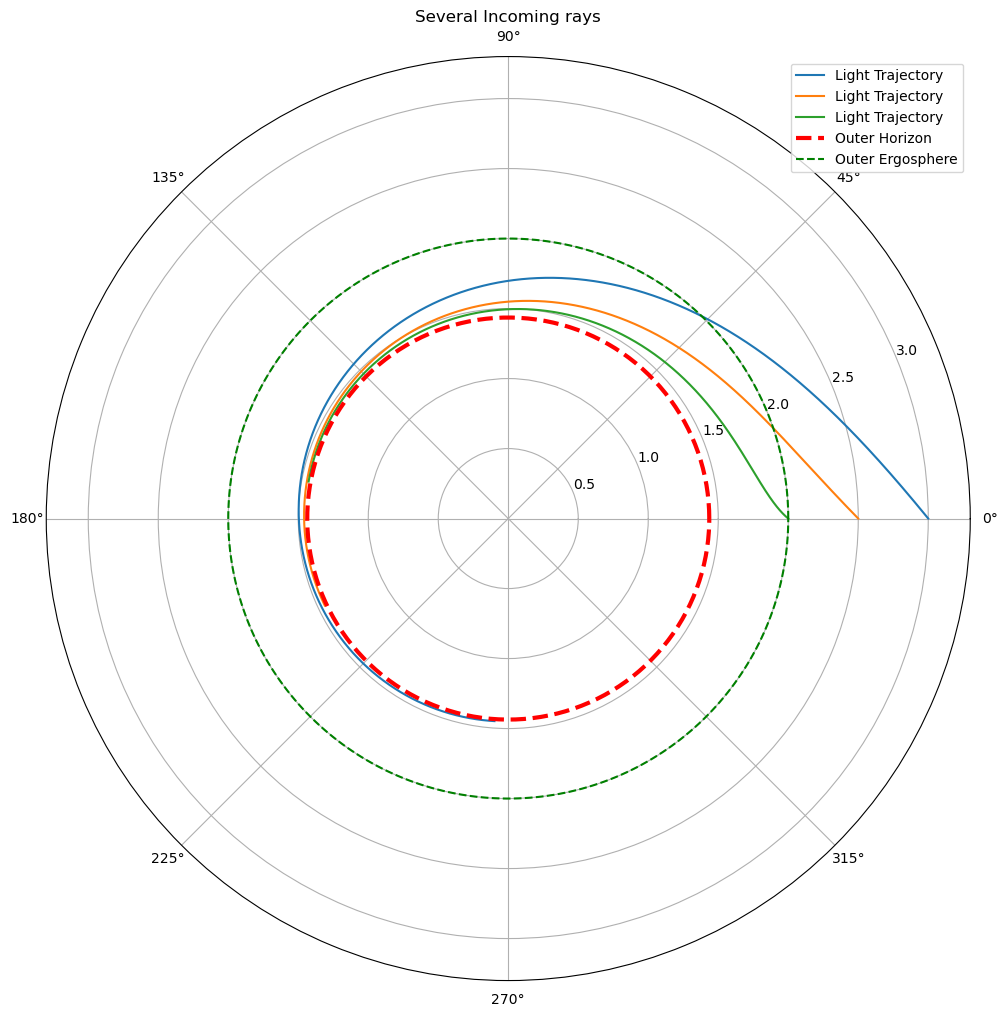

In [105]:
from copy import deepcopy
#black hole params
a=0.9#BH spin param
M=1 #BH mass param
s=2*M #BH schwartzchild radius

#horizon radii
r_h=(s+np.sqrt(s**2-4*a**2))/2
r_hi=(s-np.sqrt(s**2-4*a**2))/2

#ergoregion (valid only in equatorial plane)
r_e=2*M
r_ei=0

#photon orbit
r_prograde_photon_orbit=s*(1+np.cos(2/3*np.arccos(-np.abs(a)/M)))
r_cutoff=1.01*r_h#(r_h+r_prograde_photon_orbit)/2


def init_condition_completer(m,r_0,rp_0,phi_0,phip_0,t_0):
    init_cond_equation=lambda tdot : m**2 - (1-s/r_0)*tdot**2 - 2*a*s*phip_0*tdot/r_0+(r_0**2+a**2+a**2*s/r_0)*phip_0**2+rp_0**2*r_0**2/(Delta(r_0))
    try:
        tp_0_guess=(-a*s*phip_0/r_0+math.sqrt(a*a*s*phip_0*phip_0/r_0 + (1-s/r_0)*(m**2 + (r_0**2+a**2)*phip_0**2 + (r_0*rp_0)**2/Delta(r_0))))/(1-s/r_0)
        #this guess is the analytic solution assuming r is not equal to s and that initial conditions exist
    except ZeroDivisionError:
        tp_0_guess =0.05
    
    tp_0_guess,infodict,boolsuccess,message=fsolve(init_cond_equation,tp_0_guess,full_output=True)
    if boolsuccess:
        tp_0=tp_0_guess[-1]
    else:
        raise Exception("Invalid initial conditions, no value for t prime could be found")
    if tp_0 <=0:
        raise Exception("Invalid initial conditions, no positive value for t prime could be found")
        
    y_0=[t_0,phi_0,r_0,tp_0,phip_0,rp_0]
    
    return y_0

def equat_solve(init_cond,max_step_size):
    lambda0 = 0
    
    lambda_max = 100000
    
    y0 =init_cond
    
    RK = scipy.integrate.RK45(EOM, lambda0, y0, lambda_max, max_step=0.01)
    step_max = 100000
    xmu = np.zeros((step_max, 6))
    xmu[0, :] = y0
    reachedstep = 0
    for lambstep in range(1, step_max):
        try:
            RK.step()
            xmu[lambstep, :] = RK.y
            reachedstep = lambstep
        except RuntimeError:
            break
        finally:
            if (xmu[lambstep, 2] < r_cutoff):
                break
            if (xmu[lambstep, 2] > 20 * r_0):
                break
    
    x_trunc = xmu[0:reachedstep, :]  #x without the trailing zero rows
    traj=deepcopy(x_trunc)
    return traj

    #polar plot
def setup_polar_plot():
    fig1, ax1 = plt.subplots(figsize=(12,12),subplot_kw={'projection':'polar'})
    return ax1

def plot_horizons(axes):
    numpts=300
    th_hor=np.linspace(0,2*np.pi,num=numpts)
    ones_arr=np.ones((numpts))
    rh_arr=ones_arr*r_h
    rhi_arr=ones_arr*r_hi
    re_arr=ones_arr*r_e
    #plot horizon
    axes.plot(th_hor,rh_arr,'r--',label='Outer Horizon',linewidth=3)
    axes.plot(th_hor,re_arr,'g--',label='Outer Ergosphere')
    plt.legend()
    
def plot_traj_rad(traj,axes):
    #plot trajectory
    axes.plot(traj[:,1],traj[:,2],label='Light Trajectory')
    #axes.plot(th_hor,rhi_arr)
    plt.title("Radius vs Phi")
    plt.ylim([0,r_0*1])

    return

def plot_radius_intime(traj):
    tmin=np.min(traj[:,0])
    tmax=np.max(traj[:,0])
    plt.figure(figsize=(6,6))
    plt.plot(traj[:,0],traj[:,2],'-o',label='Light Trajectory')
    plt.plot([tmin, tmax],[r_h,r_h],label="Outer Horizon")
    plt.plot([tmin, tmax],[r_hi,r_hi],label="Inner Horizon")
    plt.plot([tmin, tmax],[r_e,r_e],label="Outer Ergosphere")
    plt.xlabel("t")
    plt.ylabel("Radius r")
    plt.title("Radius vs Coordinate Time")
    plt.ylim([0,r_0*1.5])
    plt.legend()
    return

pol_axes=setup_polar_plot()
#particle 1

m=0.00 #particle mass
r_0=3 #initial radial pos
rp_0=-0.005 #initial radial (pseudo?)momentum

phi_0=0 #initial angular pos
phip_0=0.00204#initial angular (pseudo?)momentum

t_0=0

part1_y0=init_condition_completer(m,r_0,rp_0,phi_0,phip_0,t_0)
part1_y=equat_solve(part1_y0,0.01)
plot_traj_rad(part1_y,pol_axes)

#particle 2

m=0.00 #particle mass
r_0=2.5 #initial radial pos
rp_0=-0.005 #initial radial (pseudo?)momentum

phi_0=0 #initial angular pos
phip_0=0.00204#initial angular (pseudo?)momentum

t_0=0
part2_y0=init_condition_completer(m,r_0,rp_0,phi_0,phip_0,t_0)
part2_y=equat_solve(part2_y0,0.01)

plot_traj_rad(part2_y,pol_axes)

#particle 3

m=0.00 #particle mass
r_0=2.00 #initial radial pos
rp_0=-0.005 #initial radial (pseudo?)momentum

phi_0=0 #initial angular pos
phip_0=0.00204#initial angular (pseudo?)momentum

t_0=0

part3_y0=init_condition_completer(m,r_0,rp_0,phi_0,phip_0,t_0)
part3_y=equat_solve(part3_y0,0.01)
plot_traj_rad(part3_y,pol_axes)


plot_horizons(pol_axes)
plt.ylim([0,3*1.1])
plt.legend()

plt.title("Several Incoming rays")

This all seems to work pretty well. A significant part of runtime for the whole notebook is just symbolically finding the christoffel symbols, and it's probably not very optimized.
Still, it runs reasonably fast overall (around 30 seconds on my desktop), and I'm not looking to break what works.
Funnily enough, it runs faster on my laptop than my desktop. This is probably because the laptop has a newer gen CPU.

When your starting radius is at or closer than the outer ergosphere, $\dot{\phi}$ MUST begin greater than zero, as frame dragging means even light cannot stand still or go the wrong way. If you plug in a negative value for $\dot{\phi}$ in this case, it will be unphysical as frame dragging should force the trajectory to follow the black hole's rotation. If you set $\dot{\phi}$ to zero, and $r$ on the ergosphere $r = r_E$, no valid solution can be found for $\dot{t}$.

My code now throws errors when supplied with invalid starting conditions, though there might be edge cases I haven't thought of that will make it solve unphysical trajectories. Still, I don't think there are any situations where it does that now that it makes sure $\dot{t}$ is positive and nonzero, and that it did converge to a solution for $\dot{t}$.


Params for an orbit with lots of loops before escape

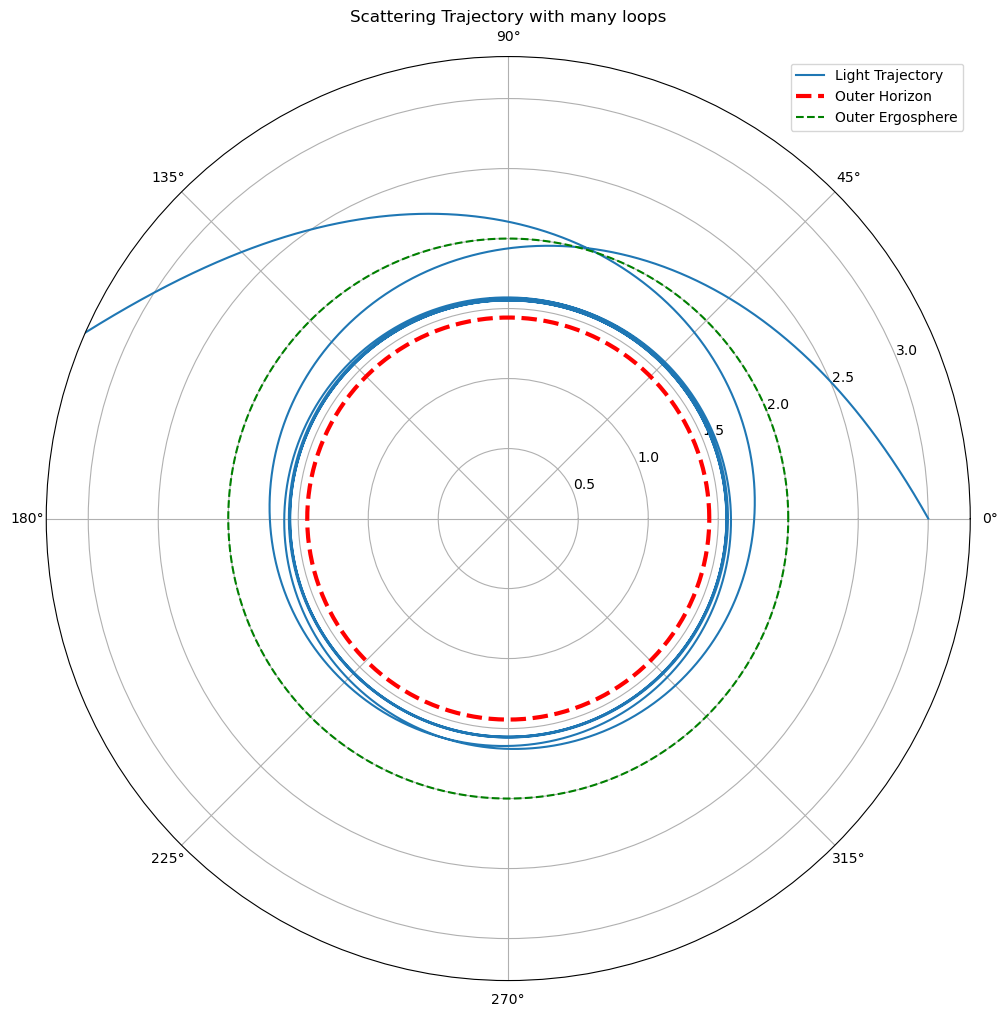

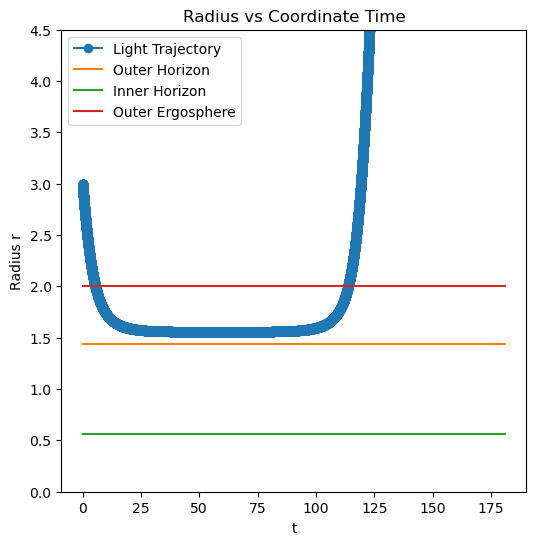

In [106]:
#starting conditions for a lot of loops before escape!

#black hole params
a=0.9 #BH spin param
M=1 #BH mass param
s=2*M #BH schwartzchild radius

r_h=(s+np.sqrt(s**2-4*a**2))/2
r_hi=(s-np.sqrt(s**2-4*a**2))/2
#ergoregion (valid only in equatorial plane)
r_e=2*M
r_ei=0

#test particle
m=0.00 #particle mass
r_0=3 #initial radial pos
rp_0=-0.05 #initial radial (pseudo?)momentum

phi_0=0 #initial angular pos
phip_0=0.029600899#initial angular (pseudo?)momentum

t_0=0

pol_axes=setup_polar_plot()
loop_0=init_condition_completer(m,r_0,rp_0,phi_0,phip_0,t_0)
loop_y=equat_solve(loop_0,0.01)
plot_traj_rad(loop_y,pol_axes)
plot_horizons(pol_axes)
plt.ylim([0,r_0*1.1])
plt.legend()
plt.title("Scattering Trajectory with many loops")

plot_radius_intime(loop_y)

Params for the prograde photon orbit:

Text(0.5, 1.0, 'Prograde Photon Orbit')

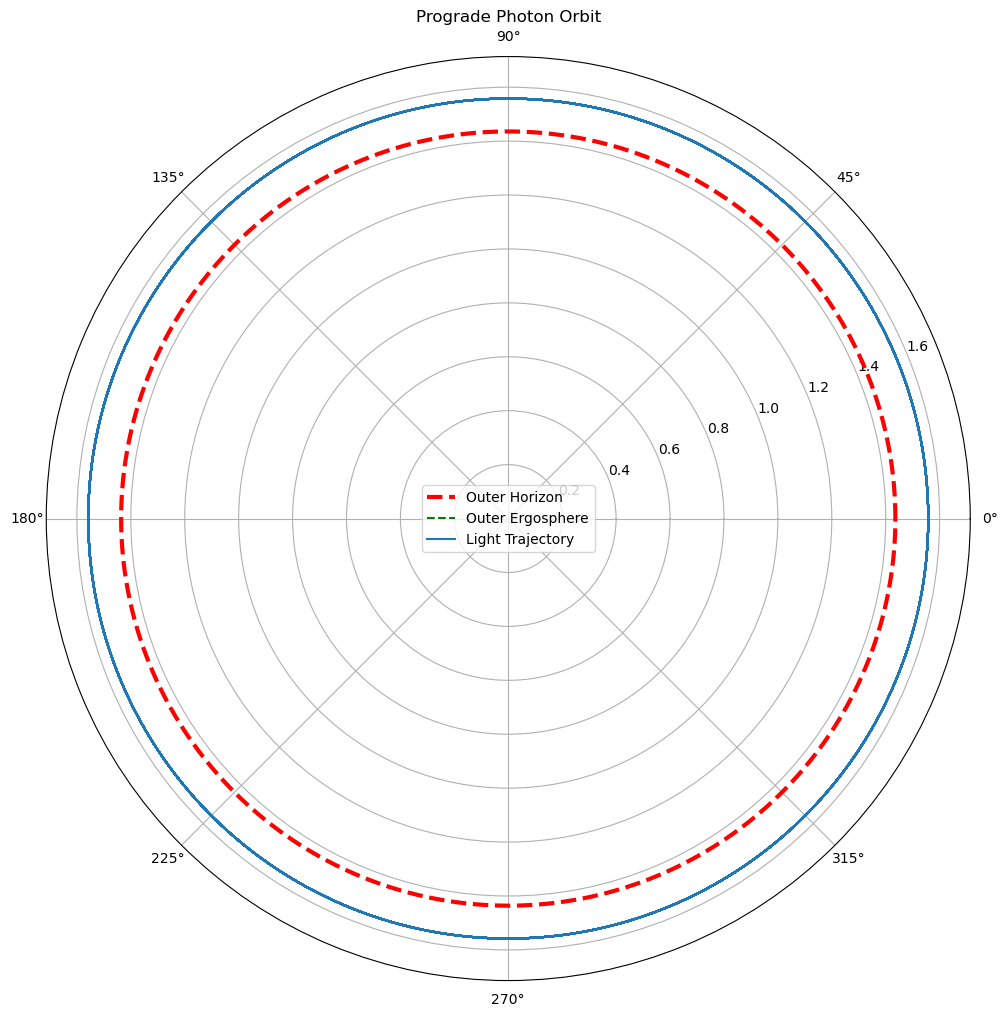

In [107]:
#black hole params
a=0.9 #BH spin param
M=1 #BH mass param
s=2*M #BH schwartzchild radius

#horizon radii
r_h=(s+np.sqrt(s**2-4*a**2))/2
r_hi=(s-np.sqrt(s**2-4*a**2))/2

#ergoregion (valid only in equatorial plane)
r_e=2*M
r_ei=0

#test particle
m=0.00 #particle mass
r_0=s*(1+np.cos(2/3*np.arccos(-np.abs(a)/M))) #initial radial pos
rp_0=0#initial radial momentum

phi_0=0 #initial angular pos
phip_0=0.1#initial angular momentum

t_0=0

pol_axes=setup_polar_plot()
orb_0=init_condition_completer(m,r_0,rp_0,phi_0,phip_0,t_0)
orb_y=equat_solve(orb_0,0.01)
plot_horizons(pol_axes)
plot_traj_rad(orb_y,pol_axes)

plt.ylim([0,r_0*1.1])
plt.legend()
plt.title("Prograde Photon Orbit")


params for the retrograde photon orbit:

Text(0.5, 1.0, 'Retrograde Photon Orbit')

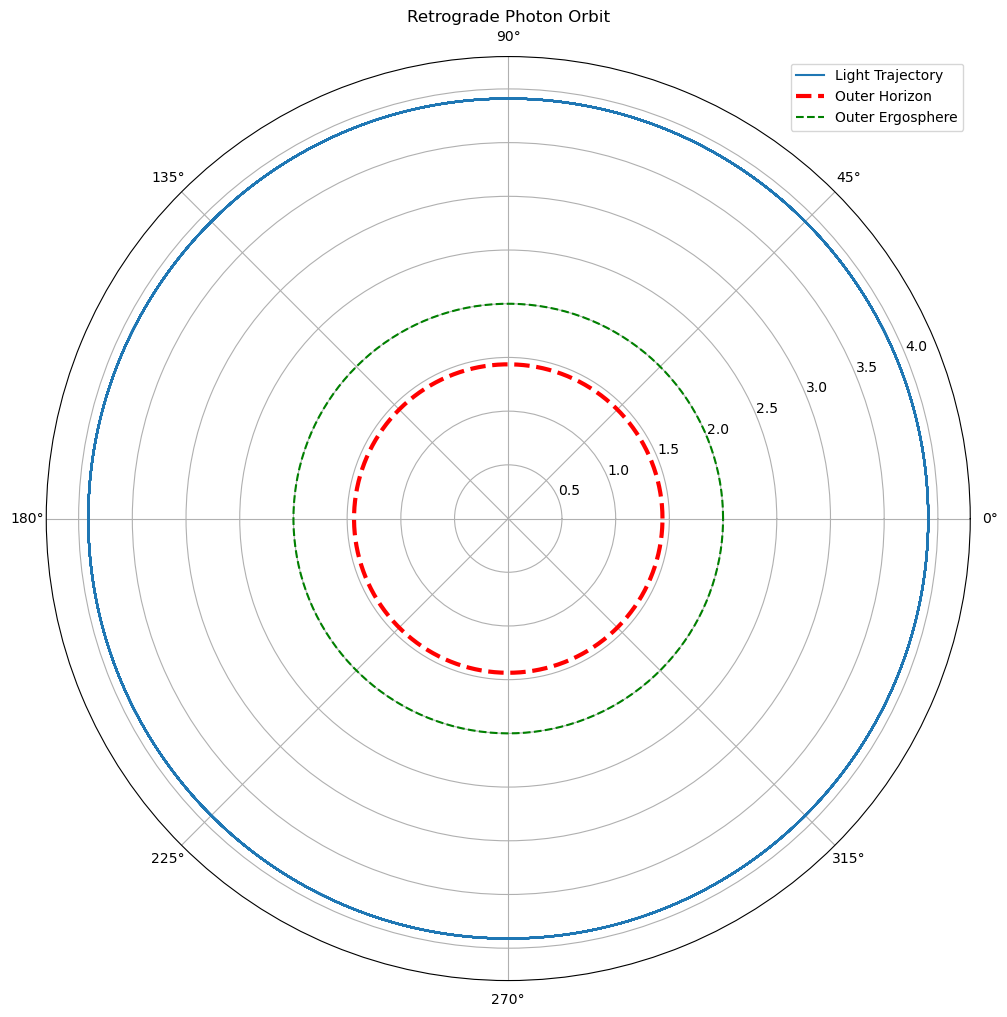

In [108]:
#black hole params
a=0.9 #BH spin param
M=1 #BH mass param
s=2*M #BH schwartzchild radius

#horizon radii
r_h=(s+np.sqrt(s**2-4*a**2))/2
r_hi=(s-np.sqrt(s**2-4*a**2))/2

#ergoregion (valid only in equatorial plane)
r_e=2*M
r_ei=0

#test particle
m=0.00 #particle mass
r_0=s*(1+np.cos(2/3*np.arccos(np.abs(a)/M))) #initial radial pos
rp_0=0#initial radial momentum

phi_0=0 #initial angular pos
phip_0=-0.1#initial angular momentum

t_0=0

pol_axes=setup_polar_plot()
orb_0=init_condition_completer(m,r_0,rp_0,phi_0,phip_0,t_0)
orb_y=equat_solve(orb_0,0.01)
plot_traj_rad(orb_y,pol_axes)
plot_horizons(pol_axes)
plt.ylim([0,r_0*1.1])
plt.legend()
plt.title("Retrograde Photon Orbit")

Incoming photon with no angular momentum.

Text(0.5, 1.0, 'Zero Angular Momentum Incoming Photon')

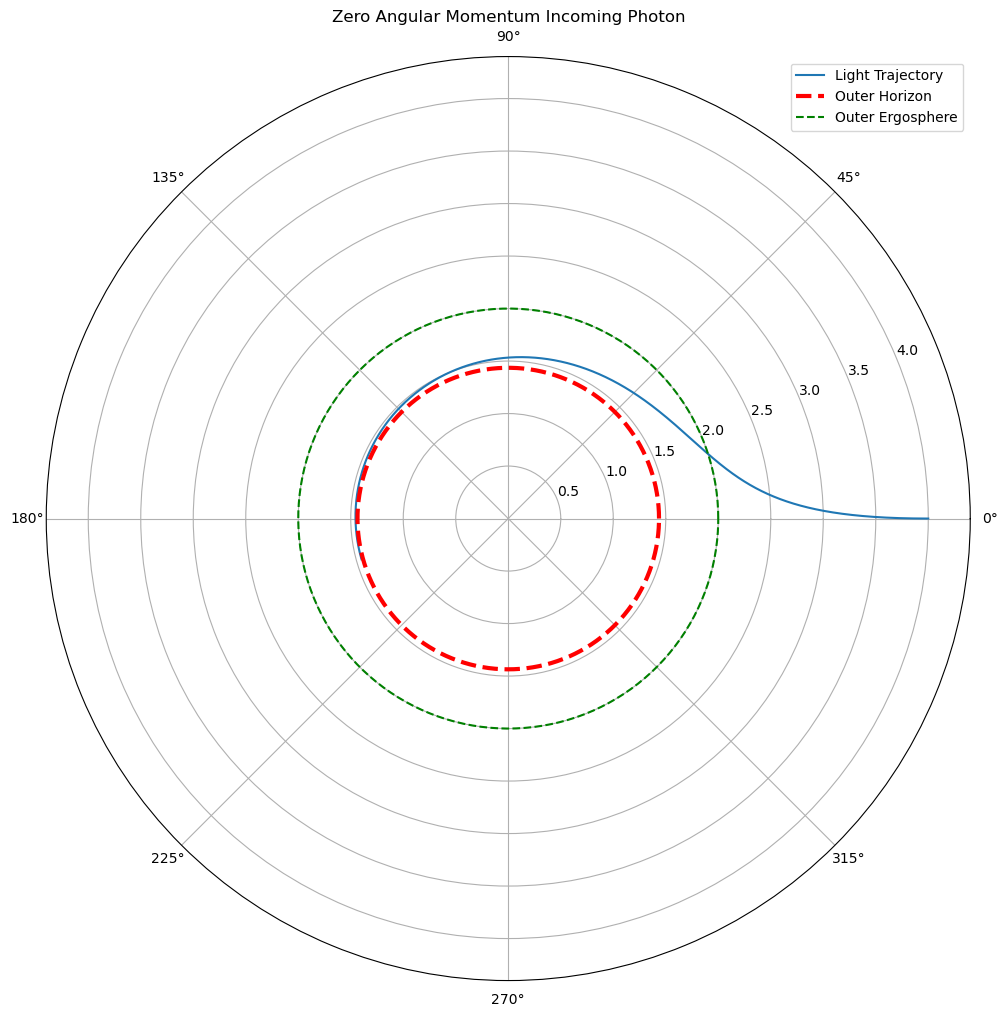

In [109]:
#black hole params
a=0.9 #BH spin param
M=1 #BH mass param
s=2*M #BH schwartzchild radius

#horizon radii
r_h=(s+np.sqrt(s**2-4*a**2))/2
r_hi=(s-np.sqrt(s**2-4*a**2))/2

#ergoregion (valid only in equatorial plane)
r_e=2*M
r_ei=0

#test particle
m=0.00 #particle mass
r_0=2*r_e #initial radial pos
rp_0=-0.01#initial radial momentum

phi_0=0 #initial angular pos
phip_0=0#initial angular momentum

t_0=0

pol_axes=setup_polar_plot()
orb_0=init_condition_completer(m,r_0,rp_0,phi_0,phip_0,t_0)
orb_y=equat_solve(orb_0,0.01)
plot_traj_rad(orb_y,pol_axes)
plot_horizons(pol_axes)
plt.ylim([0,r_0*1.1])
plt.legend()
plt.title("Zero Angular Momentum Incoming Photon")

One can already see frame dragging significantly affecting the photon trajectory outside of the ergosphere. The ergosphere just marks where that rotation cannot be overcome, even by light.